# ECE 9039 Project
### Kaggle compete title: Real or Not? NLP with Disaster Tweets
### URL: https://www.kaggle.com/c/nlp-getting-started/data
### Team member: Haoran Ding ( 251099437 )       Zhaokai Sun ( 251094021 )
### ------------------------------------------------------------------------------------------

## 1. Python and data preparation
### 1.1. Import package

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc

from pandas.core.frame import DataFrame

Using TensorFlow backend.


### 1.2. Import data

In [2]:
# Identify the device name of the laptop and select the path of the data set

import os
import socket
device_name = socket.gethostname()

if device_name =='DESKTOP-18PRE38':
    data = pd.read_csv('C:/Users/s-zk/Documents/Jupyter Files/project/data/train.csv')
else :
    data = pd.read_csv('/Users/achilles/Desktop/Machine Learning/project/nlp-getting-started/train.csv')
    
# Overview Data Set

data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


### 1.3. Data set overview

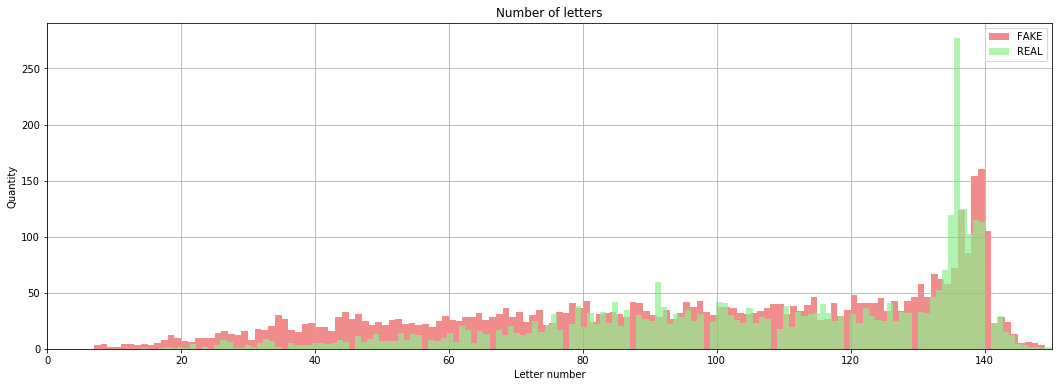

In [3]:
# Compare the number of letters

plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(data[data['target'] == 0]['text'].str.len(), alpha = 0.9, bins=bins, label='FAKE', color='lightcoral')
plt.hist(data[data['target'] == 1]['text'].str.len(), alpha = 0.7, bins=bins, label='REAL', color='lightgreen')
plt.xlabel('Letter number')
plt.ylabel('Quantity')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.title('Number of letters')
plt.show()

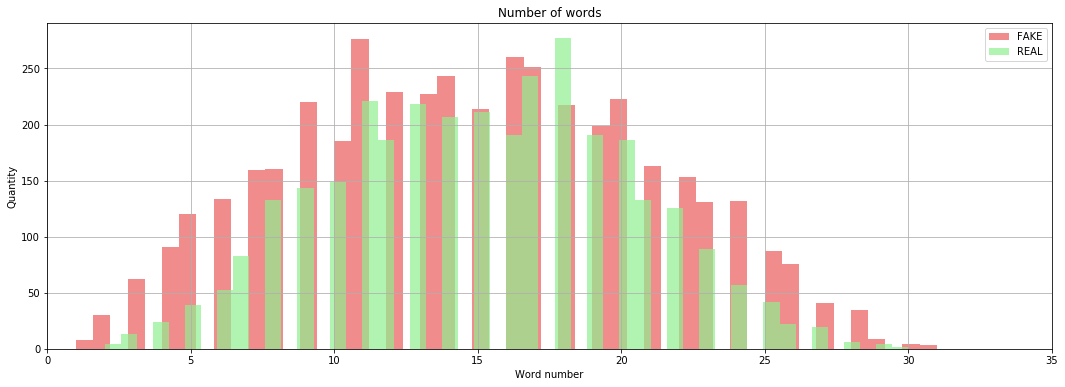

In [4]:
# Compare the number of words

plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 50
plt.hist(data[data['target'] == 0]['text'].str.split().map(lambda x: len(x)), alpha = 0.9, bins=bins, label='FAKE', color='lightcoral')
plt.hist(data[data['target'] == 1]['text'].str.split().map(lambda x: len(x)), alpha = 0.7, bins=bins, label='REAL', color='lightgreen')
plt.xlabel('Word number')
plt.ylabel('Quantity')
plt.legend(loc='upper right')
plt.xlim(0,35)
plt.grid()
plt.title('Number of words')
plt.show()

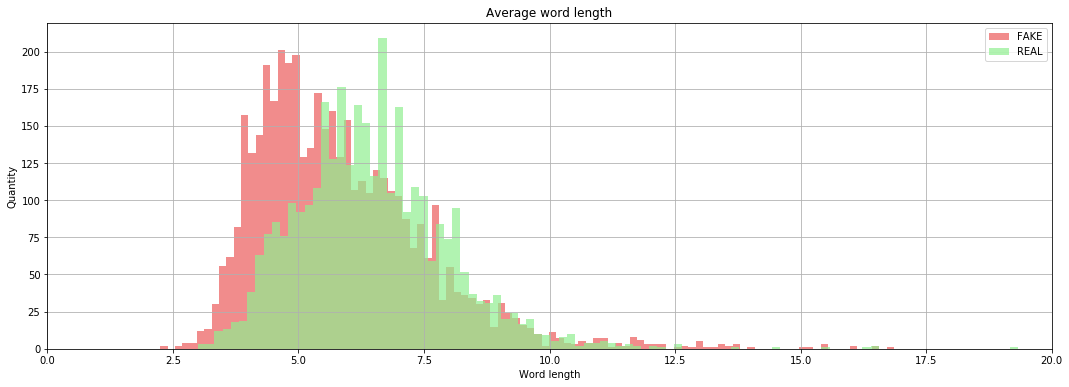

In [5]:
# Compare the average word length

plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 100
word=data[data['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
plt.hist(word.map(lambda x: np.mean(x)), alpha = 0.9, bins=bins, label='FAKE', color='lightcoral')
word=data[data['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
plt.hist(word.map(lambda x: np.mean(x)), alpha = 0.7, bins=bins, label='REAL', color='lightgreen')
plt.xlabel('Word length')
plt.ylabel('Quantity')
plt.legend(loc='upper right')
plt.xlim(0,20)
plt.grid()
plt.title('Average word length')
plt.show()

## 2. Data preprocessing
### 2.1. Handling missing values and meaningless columns

In [6]:
# Count the missing values of each column and calculate the missing percentage

missingvalue = data.isna().sum().sort_values(ascending=False)
missingpercent = (data.isna().sum()/data.isna().count()).sort_values(ascending=False)
missing_data = pd.concat([missingvalue, missingpercent], axis=1, keys=['Number of missing values', 'Missing percentage'])
missing_data.head(data.shape[1])

,Number of missing values,Missing percentage
location,2533,0.332720
keyword,61,0.008013
target,0,0.000000
text,0,0.000000
id,0,0.000000


In [7]:
# Drop columns with missing percentages that are too high (keyword & location), and meaningless columns (id)

data = data.drop(['keyword','location','id'], axis=1)

# Overview Data Set

data

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


### 2.2. Check sample distribution

0    4342
1    3271
Name: target, dtype: int64

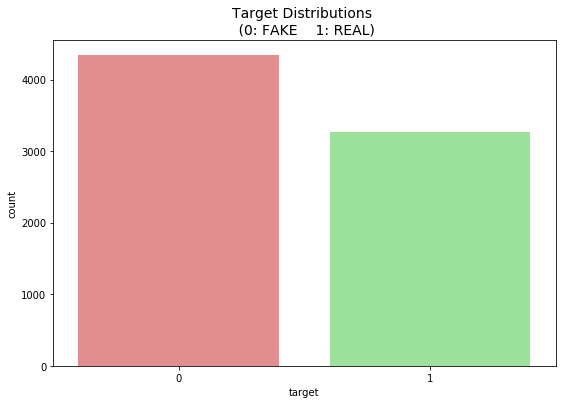

In [8]:
# Check if the distribution of positive and negative data is even

plt.rcParams['figure.figsize'] = (9.0, 6.0)
sns.countplot('target', data=data, palette=["lightcoral", "lightgreen"])
plt.title('Target Distributions \n (0: FAKE    1: REAL)', fontsize=14)
data.target.value_counts()

### 2.3. Modify the letter format

In [9]:
# Overview column "text"

data["text"]

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [10]:
# Create a corpus

corpus  = []
pstem = PorterStemmer()

for i in range(data['text'].shape[0]):
    
    # Remove http URL
    tweet = re.compile(r'https?://\S+|www\.\S+').sub(r'',data['text'][i])

    # Remove unwanted words, keep English words only
    tweet = re.sub("[^a-zA-Z]", ' ', tweet)
    
    # Transform all words to lowercase
    tweet = tweet.lower()
    
    # Sentence and word segmentation
    tweet = nltk.word_tokenize(tweet)
    
    # Word type classification
    lemma = nltk.WordNetLemmatizer()
    tweet = [ lemma.lemmatize(word) for word in tweet]
    
    # Remove stopwords
    tweet = [pstem.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    
    # Append cleaned tweet to corpus
    corpus.append(tweet)

In [11]:
# Compare the conversion results

TextBefore = data["text"].head(10)
TextAfter = pd.DataFrame(corpus, columns=['After data cleaning']).head(10)
contrast = pd.concat([TextBefore, TextAfter], axis=1, sort=False)
contrast.columns = ['Before data cleaning','After data cleaning']
contrast

,Before data cleaning,After data cleaning
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquak may allah forgiv u
1,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo rubi alaska smoke wildfir pour ...
5,#RockyFire Update => California Hwy. 20 closed...,rockyfir updat california hwi close direct due...
6,#flood #disaster Heavy rain causes flash flood...,flood disast heavi rain caus flash flood stree...
7,I'm on top of the hill and I can see a fire in...,top hill see fire wood
8,There's an emergency evacuation happening now ...,emerg evacu happen build across street
9,I'm afraid that the tornado is coming to our a...,afraid tornado come area


In [12]:
# Create dataset for GloVe

cleandata = pd.concat([ pd.DataFrame(corpus, columns=['After data cleaning']) , data["target"] ], axis=1, sort=False)
cleandata.columns = ['text','target']
cleandata

,text,target
0,deed reason earthquak may allah forgiv u,1
1,forest fire near la rong sask canada,1
2,resid ask shelter place notifi offic evacu she...,1
3,peopl receiv wildfir evacu order california,1
4,got sent photo rubi alaska smoke wildfir pour ...,1
...,...,...
7608,two giant crane hold bridg collaps nearbi home,1
7609,aria ahrari thetawniest control wild fire cali...,1
7610,utc km volcano hawaii,1
7611,polic investig e bike collid car littl portug ...,1


### 2.4. Analyze word frequency

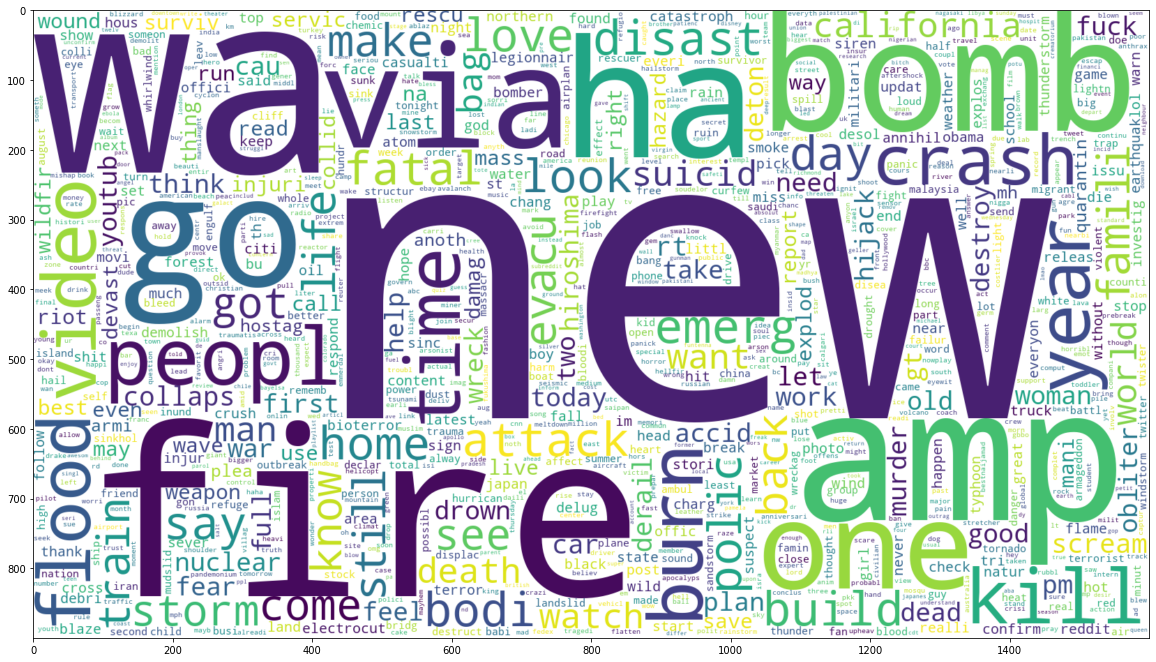

In [13]:
# Use word clouds to get an overview of the corpus

from wordcloud import WordCloud

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000,
               background_color="white",
               random_state=42,
               collocations=False,
               width = 1600,
               height = 900).generate(" ".join(corpus))
plt.imshow(wc , interpolation = 'bilinear')

In [14]:
#Create word dictionary

uniqueWordFrequents = {}
for tweet in corpus:
    for word in tweet.split():
        if(word in uniqueWordFrequents.keys()):
            uniqueWordFrequents[word] += 1
        else:
            uniqueWordFrequents[word] = 1

In [15]:
# Analyze the proportion of words in the dictionary

WordDistribution = uniqueWordFrequents
wordlist = list(WordDistribution)
numberlist = list(WordDistribution.values())

proportionlist = {"Word":wordlist, 'Quantity':numberlist}
proportionlist = DataFrame(proportionlist)
proportionlist.sort_values(by=['Quantity'], inplace=True, ascending=False)
proportionlist['Percentage'] = proportionlist['Quantity']/proportionlist['Quantity'].sum()
proportionlist.index = range(1,len(proportionlist) + 1)
proportionlist

,Word,Quantity,Percentage
1,like,411,0.005848
2,wa,394,0.005606
3,fire,363,0.005165
4,amp,344,0.004895
5,get,311,0.004425
...,...,...,...
13014,ashestoash,1,0.000014
13015,ryt,1,0.000014
13016,hlongwan,1,0.000014
13017,monwabisi,1,0.000014


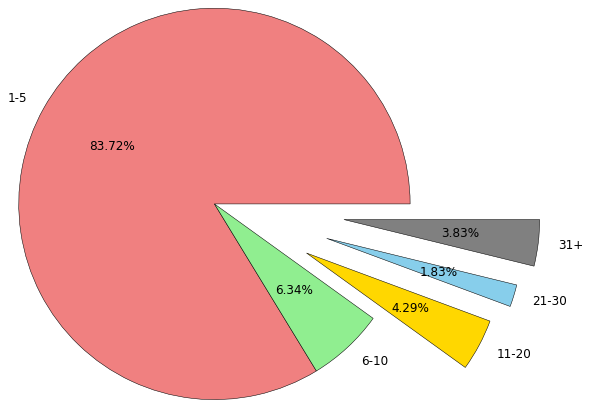

In [16]:
# Set the level and calculate the proportion of each level

countall = proportionlist['Quantity'].count()
less05 = proportionlist[proportionlist['Quantity'] <= 5]['Quantity'].count()    # 1-5
less10 = proportionlist[proportionlist['Quantity'] <= 10]['Quantity'].count() - less05    # 6-10
less20 = proportionlist[proportionlist['Quantity'] <= 20]['Quantity'].count() - less05 - less10    # 11-20
less30 = proportionlist[proportionlist['Quantity'] <= 30]['Quantity'].count() - less05 - less10 - less20    # 21-30
up31   = proportionlist[proportionlist['Quantity'] >  30]['Quantity'].count()    # 30+

piedata = [less05, less10, less20, less30, up31]
labels = ['1-5', '6-10', '11-20', '21-30', '31+']
colors = ['lightcoral','lightgreen','gold','skyblue','gray']
explode =[0,0,0.8,0.9,1]
plt.axes(aspect='equal')
plt.xlim(0,8)
plt.ylim(0,8)
plt.pie(x=piedata,
       labels=labels, 
       colors=colors,
       explode=explode,
       autopct='%.2f%%',
       radius=1.5,
       wedgeprops= {'linewidth':0.5,'edgecolor':'black'},
       textprops= {'fontsize':12,'color':'black'})
plt.show()

In [17]:
# The initial plan is to delete words which quantity of 10 or less

In [18]:
# Save as CSV file, open with excel, analyze one by one

proportionlist.to_csv( "proportionlist.csv", index=False)

In [19]:
#Convert dictionary to dataFrame

uniqueWordFrequents = pd.DataFrame.from_dict(uniqueWordFrequents,orient='index',columns=['WordFrequent'])
uniqueWordFrequents.sort_values(by=['WordFrequent'], inplace=True, ascending=False)

# Overview Word Frequents
uniqueWordFrequents

,WordFrequent
like,411
wa,394
fire,363
amp,344
get,311
...,...
ashestoash,1
ryt,1
hlongwan,1
monwabisi,1


In [20]:
# Drop the word which quantity is less than or equal to 10

uniqueWordFrequents = uniqueWordFrequents[uniqueWordFrequents['WordFrequent'] > 10]

# Overview Word Frequents

uniqueWordFrequents

,WordFrequent
like,411
wa,394
fire,363
amp,344
get,311
...,...
size,11
mr,11
catch,11
sing,11


In [21]:
# Drop the word which quantity is greater than 365

uniqueWordFrequents = uniqueWordFrequents[uniqueWordFrequents['WordFrequent'] < 365]

# Overview Word Frequents

uniqueWordFrequents

,WordFrequent
fire,363
amp,344
get,311
u,265
ha,257
...,...
size,11
mr,11
catch,11
sing,11


In [22]:
# Delete meaningless data found by manual inspection

uniqueWordFrequents.drop(labels=["u"],inplace = True)
uniqueWordFrequents.drop(labels=["ha","get","via"],inplace = True)

# Overview Word Frequents

uniqueWordFrequents

C:\Users\s-zk\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,WordFrequent
fire,363
amp,344
bomb,239
go,235
new,228
...,...
size,11
mr,11
catch,11
sing,11


### 2.5. Create the bag of words

In [23]:
# Extract text features

counVec = CountVectorizer(max_features = uniqueWordFrequents.shape[0])
bagOfWords = counVec.fit_transform(corpus).toarray()

## 3. Modeling
### 3.1. Split training set and test set

In [24]:
# Split the data set, the training set accounts for 80%, and the test set accounts for 20%

X = bagOfWords
y = data['target']
print("X shape = ",X.shape)
print("y shape = ",y.shape)

X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.20, random_state=50, shuffle =True)

X shape =  (7613, 1288)
y shape =  (7613,)


### 3.2. Decision Tree Model

In [25]:
# Define and use algorithms

decisionTreeModel = DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = None, 
                                           splitter='best', 
                                           random_state=55)

decisionTreeModel.fit(X_train,y_train)

print("Decision Tree Classifier model run successfully")

Decision Tree Classifier model run successfully


In [26]:
# Calculate the score

y_pred = decisionTreeModel.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)

recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_pred)
print('F1: %f' % f1)

Accuracy: 0.732764
Precision: 0.709375
Recall: 0.672593
F1: 0.690494


In [27]:
# Create AccuracyTable

AccuracyTable = pd.DataFrame(
                   index=['Decision Tree', 'Neural Network', 'GloVe + Decision Tree', 'GloVe + Neural Network'],
                   columns=['Accuracy', 'Precision', 'Recall', 'F1'])

In [28]:
# Write in AccuracyTable

AccuracyTable['Accuracy'][0]= round(accuracy,4)
AccuracyTable['Precision'][0]= round(precision,4)
AccuracyTable['Recall'][0]= round(recall,4)
AccuracyTable['F1'][0]= round(f1,4)
AccuracyTable

,Accuracy,Precision,Recall,F1
Decision Tree,0.7328,0.7094,0.6726,0.6905
Neural Network,NaN,NaN,NaN,NaN
GloVe + Decision Tree,NaN,NaN,NaN,NaN
GloVe + Neural Network,NaN,NaN,NaN,NaN


### 3.3. ROC Curve for Decision Tree

No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.735


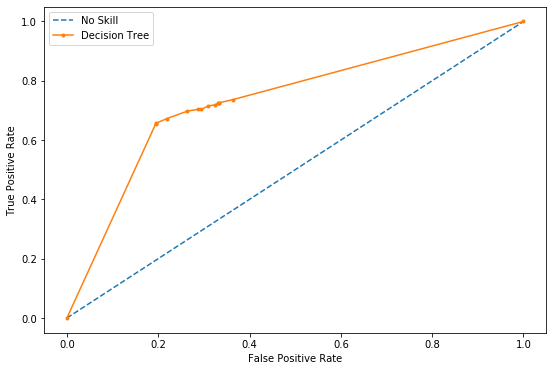

In [29]:
# Import

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

model = decisionTreeModel

# Generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# Predict probabilities
lr_probs = model.predict_proba(X_test)

# Keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# Summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Decision Tree: ROC AUC=%.3f' % (lr_auc))

# Calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# Plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Decision Tree')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

### 3.4. Neural Network

In [30]:
# Split the data set, the training set accounts for 80%, and the test set accounts for 20%

VOCAB_SIZE = 25000
MAX_LEN =90
EMBEDDING_DIM = 128

MAX_SEQUENCE_LENGTH = 250

tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(corpus)

In [31]:
# Define the structure of the neural network

model = Sequential()

model.add(Embedding(VOCAB_SIZE, 32))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

optimzer = Adam(learning_rate=1e-5)

model.compile(loss = 'binary_crossentropy',optimizer = optimzer,metrics = ['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          800000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 32)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 824,897
Trainable params: 824,897
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Split the data set, the training set accounts for 80%, and the test set accounts for 20%

X_LSTM = tokenizer.texts_to_sequences(corpus)
X_LSTM = pad_sequences(X_LSTM, maxlen=MAX_SEQUENCE_LENGTH)

y_LSTM = data['target']

X_train_LSTM , X_test_LSTM , y_train_LSTM , y_test_LSTM = train_test_split(X_LSTM,y_LSTM,test_size=0.20, random_state=50, shuffle =True)

X_train_LSTM = np.asarray(X_train_LSTM)
y_train_LSTM = np.asarray(y_train_LSTM)

In [33]:
# Start training

history = model.fit(X_train_LSTM, y_train_LSTM, epochs=8, batch_size=256, validation_split=0.1)

C:\Users\s-zk\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5481 samples, validate on 609 samples
Epoch 1/8
5481/5481 [==============================] - 13s 2ms/step - loss: 0.6932 - acc: 0.4957 - val_loss: 0.6930 - val_acc: 0.5386
Epoch 2/8
5481/5481 [==============================] - 14s 3ms/step - loss: 0.6929 - acc: 0.5216 - val_loss: 0.6927 - val_acc: 0.5632
Epoch 3/8
5481/5481 [==============================] - 15s 3ms/step - loss: 0.6926 - acc: 0.5461 - val_loss: 0.6924 - val_acc: 0.5829
Epoch 4/8
5481/5481 [==============================] - 14s 3ms/step - loss: 0.6923 - acc: 0.5674 - val_loss: 0.6921 - val_acc: 0.5796
Epoch 5/8
5481/5481 [==============================] - 15s 3ms/step - loss: 0.6921 - acc: 0.5725 - val_loss: 0.6918 - val_acc: 0.5862
Epoch 6/8
5481/5481 [==============================] - 14s 3ms/step - loss: 0.6917 - acc: 0.5787 - val_loss: 0.6915 - val_acc: 0.5764
Epoch 7/8
5481/5481 [==============================] - 15s 3ms/step - loss: 0.6915 - acc: 0.5800 - val_loss: 0.6912 - val_acc: 0.5747
Epoch 8/8
5481/

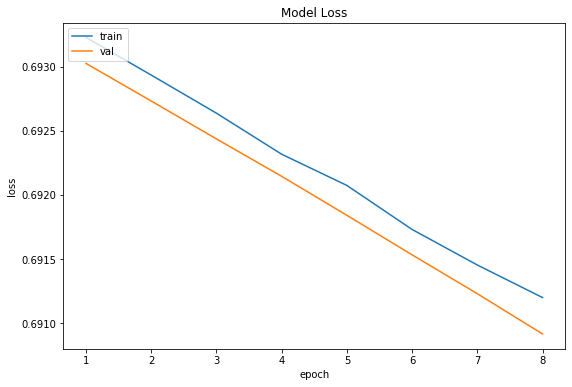

In [34]:
# Plot model loss

epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

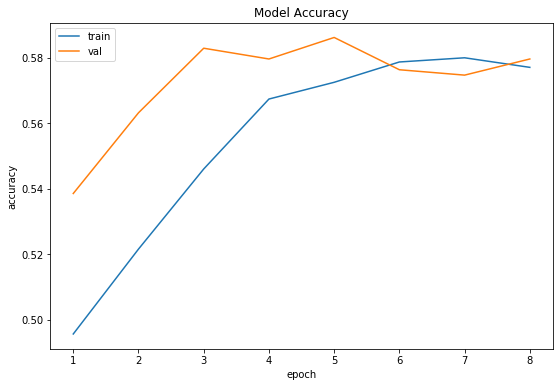

In [35]:
# Plot model accuracy

epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

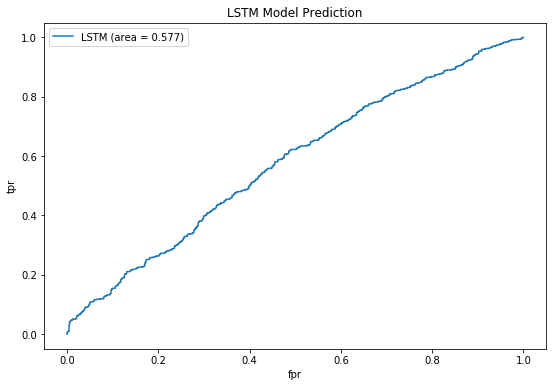

In [36]:
# Plot LSTM Model Prediction curve

y_pred_keras = model.predict(X_test_LSTM).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_LSTM, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot(fpr_keras, tpr_keras, label='LSTM (area = {:.3f})'.format(auc_keras))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('LSTM Model Prediction')
plt.legend(loc='best')
plt.show()

In [37]:
# Define prediction results

yhat_probs = model.predict(X_test_LSTM, verbose=0)
yhat_classes = model.predict_classes(X_test_LSTM, verbose=0)
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [38]:
# Calculate the score

accuracy = accuracy_score(y_test_LSTM, yhat_classes)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test_LSTM, yhat_classes)
print('Precision: %f' % precision)

recall = recall_score(y_test_LSTM, yhat_classes)
print('Recall: %f' % recall)

f1 = f1_score(y_test_LSTM, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.558766
Precision: 0.800000
Recall: 0.005926
F1 score: 0.011765


In [39]:
# Write in AccuracyTable

AccuracyTable['Accuracy'][1]= round(accuracy,4)
AccuracyTable['Precision'][1]= round(precision,4)
AccuracyTable['Recall'][1]= round(recall,4)
AccuracyTable['F1'][1]= round(f1,4)
AccuracyTable

,Accuracy,Precision,Recall,F1
Decision Tree,0.7328,0.7094,0.6726,0.6905
Neural Network,0.5588,0.8,0.0059,0.0118
GloVe + Decision Tree,NaN,NaN,NaN,NaN
GloVe + Neural Network,NaN,NaN,NaN,NaN


## 4. GloVe
### 4.1. Define a new corpus for GloVe

In [40]:
# Define a new corpus

def create_corpus_new(df):
    corpus = []
    for tweet in tqdm(df['text']):
        words = [word.lower() for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus   

In [41]:
# Create new corpus

corpus = create_corpus_new(cleandata)

100%|████████████████████████████████████████████████████████████████████████████| 7613/7613 [00:00<00:00, 7967.52it/s]


### 4.2. Load the pre-trained word vectors

In [42]:
# Download and load pre-trained word vectors (Wikipedia 2014 + Gigaword 5)
# URL: https://github.com/stanfordnlp/GloVe

embedding_dict = {}
with open('C:/Users/s-zk/Documents/Jupyter Files/project/glove/glove.6B.300d.txt','r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors
f.close()

In [43]:
# Count the number of words

MAX_LEN = 50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)

tweet_pad = pad_sequences(sequences,maxlen = MAX_LEN,truncating = 'post',padding = 'post')

word_index = tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 13018


In [44]:
# Convert

num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words,300))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec = embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

100%|████████████████████████████████████████████████████████████████████████| 13018/13018 [00:00<00:00, 435081.71it/s]


### 4.3. Create the Neural Network

In [45]:
# Define the structure of the neural network

model = Sequential()

embedding = Embedding(num_words,300,embeddings_initializer = Constant(embedding_matrix),
                   input_length = MAX_LEN,trainable = False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(1, activation = 'sigmoid'))

optimzer = Adam(learning_rate=1e-5)

model.compile(loss = 'binary_crossentropy',optimizer = optimzer,metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 300)           3905700   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 300)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 3,999,205
Trainable params: 93,505
Non-trainable params: 3,905,700
_________________________________________________________________


In [46]:
# Split the data set, the training set accounts for 80%, and the test set accounts for 20%

train = tweet_pad[:cleandata.shape[0]]
test = tweet_pad[cleandata.shape[0]:]

X_train,X_test,y_train,y_test=train_test_split(train,cleandata['target'].values,test_size=0.20)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6090, 50)
Shape of Validation  (1523, 50)


### 4.4. Train the Neural Network

In [47]:
# Start training

history = model.fit(X_train,y_train,batch_size = 8,epochs = 15,validation_data = (X_test,y_test),verbose = 2)

Train on 6090 samples, validate on 1523 samples
Epoch 1/15
 - 20s - loss: 0.6919 - accuracy: 0.5660 - val_loss: 0.6900 - val_accuracy: 0.5798
Epoch 2/15
 - 21s - loss: 0.6874 - accuracy: 0.5688 - val_loss: 0.6790 - val_accuracy: 0.5798
Epoch 3/15
 - 21s - loss: 0.6412 - accuracy: 0.6414 - val_loss: 0.5731 - val_accuracy: 0.7544
Epoch 4/15
 - 21s - loss: 0.5961 - accuracy: 0.7079 - val_loss: 0.5349 - val_accuracy: 0.7544
Epoch 5/15
 - 20s - loss: 0.5841 - accuracy: 0.7253 - val_loss: 0.5244 - val_accuracy: 0.7590
Epoch 6/15
 - 21s - loss: 0.5703 - accuracy: 0.7317 - val_loss: 0.5197 - val_accuracy: 0.7630
Epoch 7/15
 - 20s - loss: 0.5665 - accuracy: 0.7369 - val_loss: 0.5177 - val_accuracy: 0.7649
Epoch 8/15
 - 20s - loss: 0.5641 - accuracy: 0.7383 - val_loss: 0.5156 - val_accuracy: 0.7656
Epoch 9/15
 - 22s - loss: 0.5652 - accuracy: 0.7397 - val_loss: 0.5157 - val_accuracy: 0.7636
Epoch 10/15
 - 20s - loss: 0.5594 - accuracy: 0.7397 - val_loss: 0.5149 - val_accuracy: 0.7649
Epoch 11/15

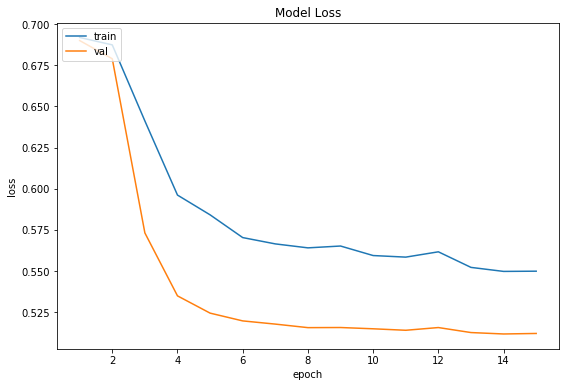

In [48]:
# Plot model loss

epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

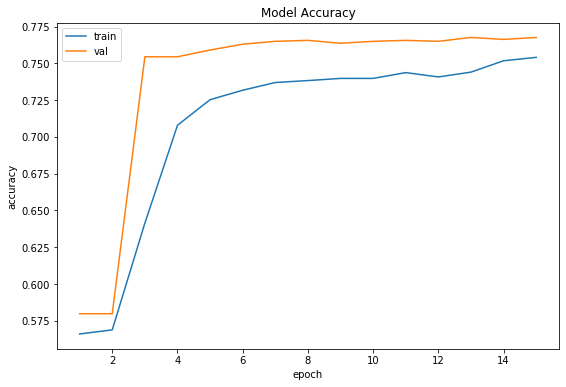

In [49]:
# Plot model accuracy

epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'])
plt.plot(epochs, history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

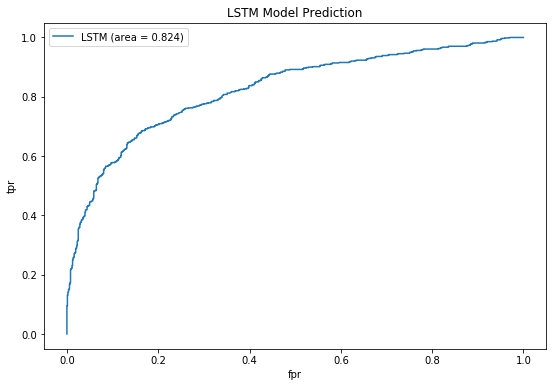

In [50]:
# Plot LSTM Model Prediction curve

y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot(fpr_keras, tpr_keras, label='LSTM (area = {:.3f})'.format(auc_keras))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('LSTM Model Prediction')
plt.legend(loc='best')
plt.show()

In [51]:
# Define prediction results

y_pred = model.predict(X_test, verbose=0)
y_classes = model.predict_classes(X_test, verbose=0)

y_pred = y_pred[:, 0]
y_classes = y_classes[:, 0]

accuracy = accuracy_score(y_test, y_classes)

In [52]:
# Calculate the accuracy

acc = accuracy_score(y_test, y_classes)
Accuracy = {}
Accuracy['GloVe + Neural Network'] = acc
print("GloVe + Neural Network Accuracy: {:.2f}%".format(acc))

GloVe + Neural Network Accuracy: 0.77%


In [53]:
# Calculate the score

accuracy = accuracy_score(y_test, y_classes)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_classes)
print('Precision: %f' % precision)

recall = recall_score(y_test, y_classes)
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_classes)
print('F1: %f' % f1)

Accuracy: 0.767564
Precision: 0.782609
Recall: 0.618750
F1: 0.691099


In [54]:
# Write in AccuracyTable

AccuracyTable['Accuracy'][3]= round(accuracy,4)
AccuracyTable['Precision'][3]= round(precision,4)
AccuracyTable['Recall'][3]= round(recall,4)
AccuracyTable['F1'][3]= round(f1,4)
AccuracyTable

,Accuracy,Precision,Recall,F1
Decision Tree,0.7328,0.7094,0.6726,0.6905
Neural Network,0.5588,0.8,0.0059,0.0118
GloVe + Decision Tree,NaN,NaN,NaN,NaN
GloVe + Neural Network,0.7676,0.7826,0.6188,0.6911


### 4.5. Try the Decision Tree

In [55]:
# Define and use algorithms

decisionTreeModel = DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = None, 
                                           splitter='best', 
                                           random_state=40)

decisionTreeModel.fit(X_train,y_train)

print("Decision Tree Classifier model run successfully")

Decision Tree Classifier model run successfully


In [56]:
# Calculate the score

y_pred = decisionTreeModel.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)

recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_pred)
print('F1: %f' % f1)

Accuracy: 0.599475
Precision: 0.523810
Recall: 0.515625
F1: 0.519685


In [57]:
# Write in AccuracyTable

AccuracyTable['Accuracy'][2]= round(accuracy,4)
AccuracyTable['Precision'][2]= round(precision,4)
AccuracyTable['Recall'][2]= round(recall,4)
AccuracyTable['F1'][2]= round(f1,4)
AccuracyTable

,Accuracy,Precision,Recall,F1
Decision Tree,0.7328,0.7094,0.6726,0.6905
Neural Network,0.5588,0.8,0.0059,0.0118
GloVe + Decision Tree,0.5995,0.5238,0.5156,0.5197
GloVe + Neural Network,0.7676,0.7826,0.6188,0.6911


### 4.6. ROC Curve for Decision Tree with GloVe

No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.587


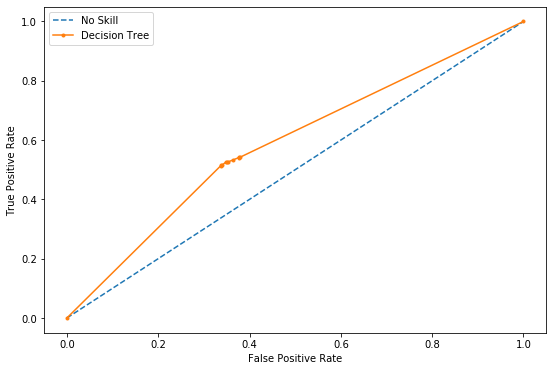

In [58]:
# Import

model = decisionTreeModel

# Generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# Predict probabilities
lr_probs = model.predict_proba(X_test)

# Keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# Summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Decision Tree: ROC AUC=%.3f' % (lr_auc))

# Calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# Plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Decision Tree')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

## 5. Final Result

In [60]:
# Print accuracy table

AccuracyTable.T

,Decision Tree,Neural Network,GloVe + Decision Tree,GloVe + Neural Network
Accuracy,0.7328,0.5588,0.5995,0.7676
Precision,0.7094,0.8,0.5238,0.7826
Recall,0.6726,0.0059,0.5156,0.6188
F1,0.6905,0.0118,0.5197,0.6911


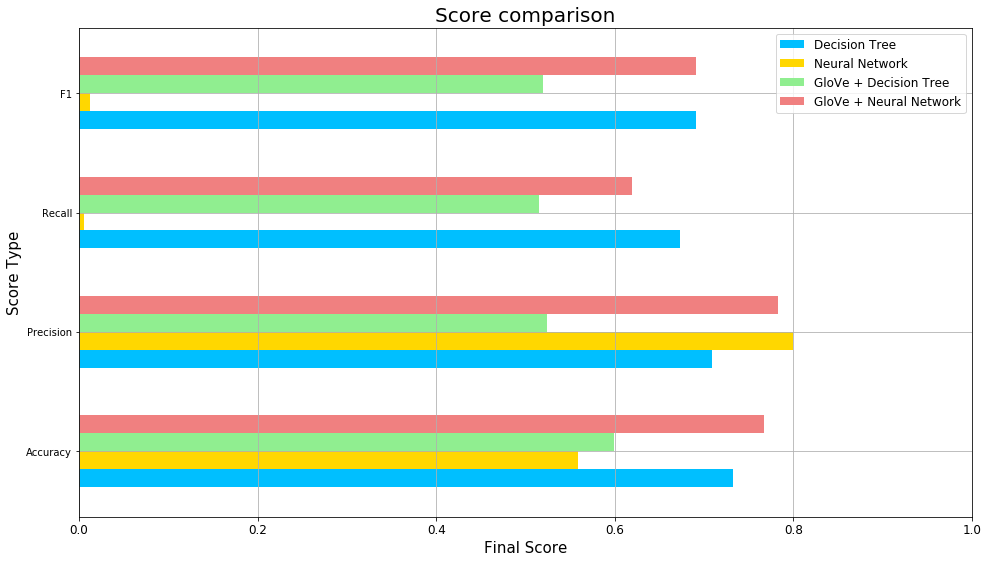

In [61]:
# Plot the bar

plt.rcParams['figure.figsize'] = (16.0, 9.0)
AccuracyTable.T.plot(kind='barh',
                     rot = 0,
                     color = ['deepskyblue', 'gold', 'lightgreen', 'lightcoral'],
                     width = 0.6,
                     )
plt.xlabel('Final Score', fontsize=15)
plt.xlim((0.0, 1.0))
plt.ylabel('Score Type', fontsize=15)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=12)
plt.grid()
plt.title('Score comparison', fontsize=20)
plt.show()